# ADS 509 Sentiment Assignment

**Lorena Dorado**

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import nltk
# nltk.download('stopwords')

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "./"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_data = defaultdict(dict)
for artist_dir in os.listdir(os.path.join(data_location, lyrics_folder)):
    artist_path = os.path.join(data_location, lyrics_folder, artist_dir)
    if os.path.isdir(artist_path):
        for lyric_file in os.listdir(artist_path):
            with open(os.path.join(artist_path, lyric_file)) as f:
                song = lyric_file.replace('.txt', '')
                lyrics_data[artist_dir][song] = f.read()

In [5]:
# Read in the twitter data
artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}

# More efficient way to read and combine the Twitter data
twitter_data = pd.concat([
    pd.read_csv(
        os.path.join(data_location, twitter_folder, filename),
        sep="\t",
        quoting=3
    ).assign(artist=artist)
    for artist, filename in artist_files.items()
])

In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. You can use a dataframe or a 
# dictionary for this.
sentiment_dict = {}

# Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1.
with open(positive_words_file, 'r', encoding='utf-8') as f:
    pos_words = [line.strip() for line in f if line.strip()]
    sentiment_dict.update({word: 1 for word in pos_words})

with open(negative_words_file, 'r', encoding='utf-8') as f:
    neg_words = [line.strip() for line in f if line.strip()]
    sentiment_dict.update({word: -1 for word in neg_words})

# Read tidytext sentiments
tidy_dict = {}
with open(tidy_text_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            word = parts[0]
            try:
                score = float(parts[1])
                tidy_dict[word] = score
            except ValueError:
                continue

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [7]:
# your code here
# Analyze sentiment of lyrics
results = []

# Clean and process each song
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        # Clean text
        text = emoji.replace_emoji(lyrics, '')
        text = re.sub(f'[{punctuation}]', ' ', text.lower())
        words = [w for w in text.split() if w not in stopwords.words("english")]
        
        if not words:
            continue
            
        # Calculate average sentiment per word
        basic_score = sum(sentiment_dict.get(word, 0) for word in words) / len(words)
        tidy_score = sum(tidy_dict.get(word, 0) for word in words) / len(words)
        
        results.append({
            'artist': artist,
            'song': song,
            'basic_sentiment': basic_score,
            'tidy_sentiment': tidy_score,
            'lyrics_length': len(words)
        })

# Create DataFrame from results
sentiment_df = pd.DataFrame(results)

In [8]:
# Print summary statistics
print("Average sentiment scores by artist:")
print(sentiment_df.groupby('artist')['basic_sentiment'].mean())

Average sentiment scores by artist:
artist
cher     0.031996
robyn    0.019057
Name: basic_sentiment, dtype: float64


In [9]:
# Print top and bottom songs analysis for each artist
n = 3  # songs

for artist in sentiment_df['artist'].unique():
    print(f"\nHighest {n} sentiment songs for {artist}:")
    artist_data = sentiment_df[sentiment_df['artist'] == artist]
    highest_songs = artist_data.nlargest(n, 'basic_sentiment')
    
    for _, row in highest_songs.iterrows():  # Remove asterisks
        print(f"\n{row['song']} (sentiment: {row['basic_sentiment']:.3f})")
        print(f"Lyrics excerpt:\n{lyrics_data[artist][row['song']]}---")
    
    print(f"\nLowest {n} sentiment songs for {artist}:")
    lowest_songs = artist_data.nsmallest(n, 'basic_sentiment')
    
    for _, row in lowest_songs.iterrows():  # Remove asterisks
        print(f"\n{row['song']} (sentiment: {row['basic_sentiment']:.3f})")
        print(f"Lyrics excerpt:\n{lyrics_data[artist][row['song']]}---")


Highest 3 sentiment songs for cher:

cher_mylove (sentiment: 0.580)
Lyrics excerpt:
"My Love"



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa
---

cher_moveme (sentiment: 0.342)
Lyrics excerpt:


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

**A: Based on the sentiment scores, Cher has the higher average sentiment per son with a score of 0.032 compared to Robyn at 0.019.**

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

**A: For Cher, the highest sentiments are songs: "My Love" (sentiment: 0.580), "Move Me" (sentiment: 0.342)
, and "My Love" (sentiment: 0.305). The lowest are "Cry Myself To Sleep" (sentiment: -0.259), "Outrageous" (sentiment: -0.224), and "It's Not Unusual" (sentiment: -0.170). The songs with upbeat and more positive lyrics appear to have higher sentiment scores. The word "love" seems to be contribute as well as balanced positive and negative words. Emotional words are also driving the scores, wether they are good or bad. The songs with repetitive lyrics also scored higher.**

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

**A: For Robyn, the highest sentiments are songs "Love Is Free" (sentiment: 0.352), "Who's That Girl" (sentiment: 0.167), and "Indestructible"
(sentiment: 0.164). The lowest are "Don't Fucking Tell Me What To Do" (sentiment: -0.490), "Don't Fucking Tell Me What To Do" (sentiment: -0.490), and "Criminal Intent" (sentiment: -0.195). Both positive and negative words (like pretty and pressure) are somewhat balanced in the top 3 songs. The lowest songs contain aggressive language (like the "f" word) with repetitive negative phrases like "killing" and "criminal".  Repetition of phrases are observed in both high and low scores. The words used are emotionally intense.**

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

**The plot below supports our analysis of the songs and sentiment scores, showing that both artists create songs with different levels emotions. Cher has more positive sentiment songs compared to Robyn's duality in positive and negative range.**



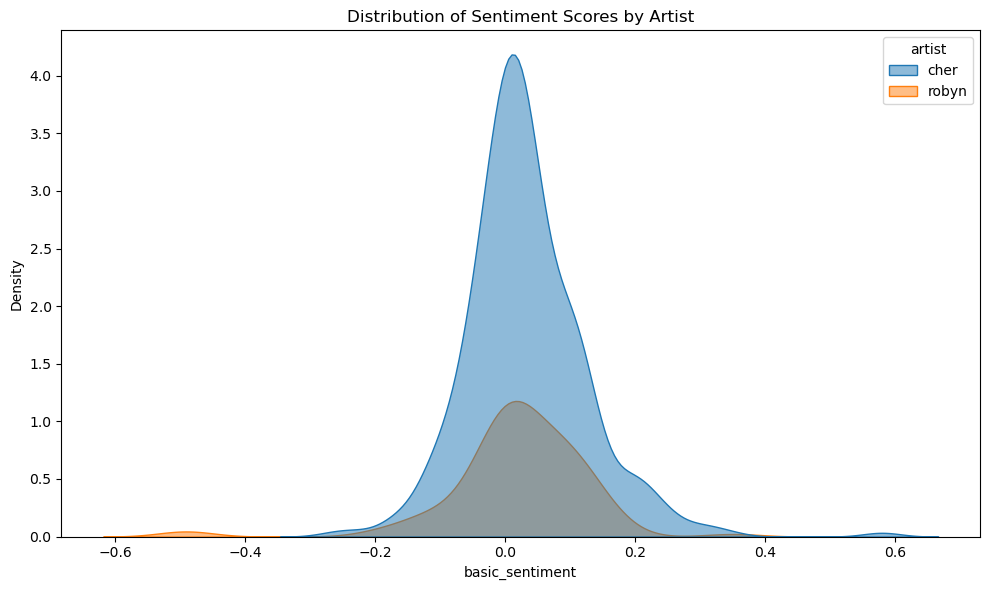

In [15]:
# Create sentiment distribution plots
plt.figure(figsize=(10, 6))
sns.kdeplot(data=sentiment_df, x='basic_sentiment', hue='artist', fill=True, alpha=0.5)
plt.title('Distribution of Sentiment Scores by Artist')
plt.tight_layout()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [11]:
# your code here
# Define positive and negative emoji sets with more contextual relevance
# Including emojis commonly used in online reviews and social media
positive_emojis = {
    '❤️': 1,  # love/affection
    '😊': 1,  # warm smile
    '🥰': 1,  # loving face
    '😍': 1,  # heart eyes
    '🌟': 1,  # sparkle/excellence
    '✨': 1,  # sparkles/magic
    '👌': 1,  # okay/perfect
    '💯': 1,  # 100/perfect score
    '🔥': 1,  # fire/awesome
    '💪': 1,  # strength/power
    '👍': 1,  # thumbs up
    '🙌': 1,  # raised hands/celebration
    '🎉': 1,  # party popper/celebration
    '💝': 1,  # heart with ribbon
    '🤩': 1   # star-struck
}

negative_emojis = {
    '😢': -1,  # crying face
    '😭': -1,  # loudly crying face
    '😔': -1,  # sad pensive face
    '💔': -1,  # broken heart
    '😕': -1,  # confused face
    '😡': -1,  # angry face
    '😤': -1,  # face with steam
    '😩': -1,  # weary face
    '😫': -1,  # tired face
    '😖': -1,  # confounded face
    '🤬': -1,  # cursing face
    '😠': -1,  # angry face
    '👎': -1,  # thumbs down
    '😒': -1,  # unamused face
    '🙄': -1   # rolling eyes
}

In [12]:
# text preprocessing based on sentiment analysis best practices
def preprocess_text(text):
    if pd.isna(text):
        return ''
    # Convert to lowercase as mentioned in the text
    text = text.lower()
    # Remove URLs and special characters while preserving emojis
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

# emoji analysis with normalization
def analyze_sentiment(descriptions):
    if len(descriptions) == 0:
        return {
            'average_sentiment': 0,
            'emoji_counts': Counter(),
            'total_descriptions': 0,
            'descriptions_with_emoji': 0
        }
    
    total_score = 0
    all_emoji_counts = Counter()
    descriptions_with_emoji = 0
    
    for desc in descriptions:
        desc = preprocess_text(desc)
        if not desc:
            continue
            
        emoji_present = False
        desc_score = 0
        
        # Count emojis and calculate sentiment
        for emoji in positive_emojis.keys() | negative_emojis.keys():
            count = desc.count(emoji)
            if count > 0:
                emoji_present = True
                all_emoji_counts[emoji] += count
                desc_score += (positive_emojis.get(emoji, 0) + 
                             negative_emojis.get(emoji, 0)) * count
        
        if emoji_present:
            descriptions_with_emoji += 1
            total_score += desc_score
    
    # Calculate metrics
    return {
        'average_sentiment': total_score / descriptions_with_emoji if descriptions_with_emoji > 0 else 0,
        'emoji_counts': all_emoji_counts,
        'total_descriptions': len(descriptions),
        'descriptions_with_emoji': descriptions_with_emoji
    }

In [13]:
# Analyze sentiment for each artist
artist_stats = {}
for artist in twitter_data['artist'].unique():
    # Get non-null descriptions for this artist
    artist_descriptions = twitter_data[twitter_data['artist'] == artist]['description'].dropna()
    
    # Analyze sentiment
    stats = analyze_sentiment(artist_descriptions)
    artist_stats[artist] = stats

In [14]:
# Print detailed results
for artist, stats in artist_stats.items():
    print(f"\n=== {artist.upper()} ===")
    print(f"Average sentiment score: {stats['average_sentiment']:.3f}")
    print(f"Total descriptions analyzed: {stats['total_descriptions']}")
    print(f"Descriptions containing emojis: {stats['descriptions_with_emoji']} "
          f"({(stats['descriptions_with_emoji']/stats['total_descriptions']*100):.1f}%)")
    
    # Most used emojis
    if stats['emoji_counts']:
        pos_emojis = {e: c for e, c in stats['emoji_counts'].items() if e in positive_emojis}
        neg_emojis = {e: c for e, c in stats['emoji_counts'].items() if e in negative_emojis}
        
        top_pos = max(pos_emojis.items(), key=lambda x: x[1]) if pos_emojis else ('None', 0)
        top_neg = max(neg_emojis.items(), key=lambda x: x[1]) if neg_emojis else ('None', 0)
        
        print(f"Most popular positive emoji: {top_pos[0]} (used {top_pos[1]} times)")
        print(f"Most popular negative emoji: {top_neg[0]} (used {top_neg[1]} times)")


=== CHER ===
Average sentiment score: 1.320
Total descriptions analyzed: 2000921
Descriptions containing emojis: 87195 (4.4%)
Most popular positive emoji: ❤️ (used 47388 times)
Most popular negative emoji: 💔 (used 1610 times)

=== ROBYN ===
Average sentiment score: 1.350
Total descriptions analyzed: 190023
Descriptions containing emojis: 5196 (2.7%)
Most popular positive emoji: ❤️ (used 3010 times)
Most popular negative emoji: 💔 (used 60 times)


Q: What is the average sentiment of your two artists? 

**A: Cher's average score is 1.320 and Robyn's average score is 1.350. They are both similar sentiment scores, but Robyn seems to have more positive followers.**

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

**A: The most popular positive emoji for Cher is the positive heart emoji. The most popular positive emoji for Robyn is also the positive heart emoji.
The most popular negative emoji for Cher is the heartbreak emoji. The most popular negative emoji for Robyn is also the heartbreak emoji. Both fanbases use the same positive emoji and also outnumber the negative emoji.**



**References**

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python: Machine learning-based solutions for common real-world (NLP) applications [GitHub repository]. O’Reilly. https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master

OpenAI. (2025). ChatGPT [Large language model]. OpenAI.